In [1]:
"""
Data exploration and basic regression on the Ames, Iowa Kaggle dataset

Objective: predict sales price given the numerical and 
categorical features in the dataset.

The notebook includes basic
-data exploration
-data cleaning
-regression models: linear regression (ordinary, ridge, elastic net),
gradient boosting, random forest.
-prep for kaggle submission
"""

import os
import datetime

import numpy as np
from scipy.stats import skew
import pandas as pd
from pandas.tools.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV
from sklearn import ensemble

import warnings
warnings.filterwarnings('ignore')

FILE_PATH = 'data/'
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'


def load_data(path, file):
    """Load data into pandas DataFrame"""
    data_path = os.path.join(path, file)
    return pd.read_csv(data_path)


def process_null(train, test, drop_thres=0.33): 
    """Process null values in train/test datasets.
    
    -Features with more null > drop_threshold are dropped
    from the datasets. 
    -Null cells for numerical features are replaced with the 
    mean of that feature.
    -Nulls cells for categorical features are replaced with
    most common value for that feature.
    """

    # get percent null for each feature
    percent_null = train.isnull().sum() / train.shape[0]
    delete_cols = percent_null[percent_null > drop_thres]
    # delete features with null proportion > drop_thres
    for df in [train, test]:
        df.drop(delete_cols.index.tolist(), axis=1, inplace=True)
    
    # get remaining features
    features = get_features(test)
    
    # fill null values
    for df in [train, test]:
        for feature in features['numerical']:
            # replace numerical nulls with mean of feature
            df[feature].fillna(train[feature].mean(), inplace=True)
        for feature in features['categorical']:
            # replace categorical nulls with most common value
            df[feature].fillna(train[feature].
                               value_counts().idxmax(), inplace=True)
    
    return train, test


def get_features(df):
    """Get numerical and categorical feature names."""
    features = {}
    features['numerical'] = df.select_dtypes(
        exclude=["object"]).columns.values
    features['categorical'] = df.select_dtypes(
        include=["object"]).columns.values
    return features


def transform_skewed(train, test, skew_thres=0.75):
    """Apply log transformation to skewed numerical features."""
    features = get_features(test)
    # get skew for each numerical feature
    skewness = train[features['numerical']].apply(
        lambda x: skew(x.dropna()))
    # get feature names with skewness > skew_thres
    skewed_features = skewness[skewness > skew_thres].index
    for df in [train, test]:
        # apply log to skewed features
        df[skewed_features] = np.log1p(df[skewed_features])
    return train, test


def scale_features(train, test):
    """Apply scaling to numerical features.
    
    Min-max scaling applied to preserve values that are zero, e.g. basement
    square feet is 0 for houses that do not have a basement.
    """
    features = get_features(test)
    
    # create MinMaxScaler
    minmax_scaler = MinMaxScaler().fit(train[features['numerical']])
    for df in [train, test]:
        # apply minmax scaling to each numerical feature
        df[features['numerical']] = minmax_scaler.transform(
            df[features['numerical']])
    return train, test


def rmse_cv(model, train, target, cv_num=10):
    """Compute root mean squared error over data."""
    scores = cross_val_score(model, train, target, 
                            scoring='neg_mean_squared_error', cv=cv_num)
    return np.sqrt(-scores)


def plot_actual_pred(model, X_train, y_train, X_val, y_val, title=None):
    """Plot actual vs predicted SalePrice."""
    # get predictions using trained model
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Plot predictions
    plt.scatter(y_train_pred, y_train, c = 'blue', 
                marker = 's', label = 'Training data')
    plt.scatter(y_val_pred, y_val, c = 'lightgreen', 
                marker = 's', label = 'Validation data')
    if title is not None:
        plt.title(title)
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.legend(loc = 'upper left')
    plt.plot([10.5, 13.5], [10.5, 13.5], c = 'red')
    plt.show()


def display_results(model, X_train, y_train, X_val, y_val, coef=True,
                    title='Coefficients in Regression Model'):
    """Display train/test rmse and features with largest coefficients
    using trained model.
    """
    # display train rmse
    print('train rmse:', np.average(rmse_cv(model, X_train, y_train)))
    print('valid rmse:', np.average(rmse_cv(model, X_val, y_val)))

    # slightly different plotting required for different models
    # plot bar chart with highest and lowest feature coefficients
    if coef: 
        coefs = pd.Series(model.coef_, index = X_train.columns)
        imp_coefs = pd.concat([coefs.sort_values().head(10),
                               coefs.sort_values().tail(10)])
        imp_coefs.plot(kind = 'barh')
    else: 
        coefs = pd.Series(grad_boost.feature_importances_, index = X_train.columns)
        imp_coefs = coefs.sort_values(ascending=False).head(10)
        imp_coefs.plot(kind = 'barh')
        plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    

def write_to_csv(test_id, preds):
    """Create csv file for test predictions with columns Id and SalePrice."""
    now = datetime.datetime.now()
    sub_file = 'submission_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
    pd.DataFrame({'Id': test_id, 'SalePrice': preds}).to_csv(sub_file, index=False)    

In [2]:
# load train/test data 
train = load_data(FILE_PATH, TRAIN_FILE)
test = load_data(FILE_PATH, TEST_FILE)

test_id = test['Id']
# drop Id column to prevent being used in regression
for df in [train, test]:
    df.drop('Id', axis=1, inplace=True)

#### Quick data exploration

In [3]:
# size of dataset
print('train data size:', train.shape)
print('test data size:', test.shape)

train data size: (1460, 80)
test data size: (1459, 79)


Small dataset, particularly relative to the number of features. Also, it's interesting that Kaggle chose to split train and test data evenly rather than having a larger training set.

In [4]:
# quick look at dataset
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

A number of columns have missing data. We'll deal with this further below.

In [6]:
# look at mean, std, count and percentiles
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Features have very different levels so we'll want to scale the data prior to running the regression.

#### More data exploration

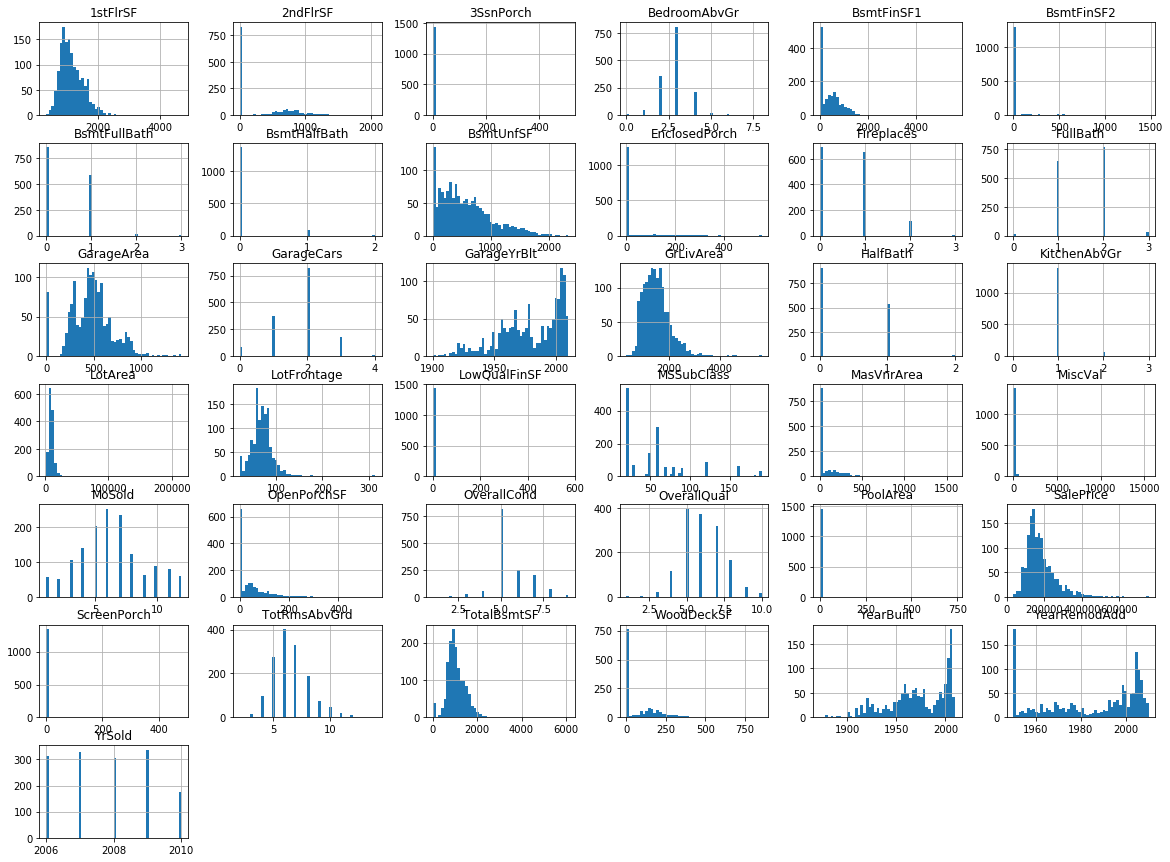

In [7]:
# plot histograms of each feature
train.hist(bins=50, figsize=(20,15))
plt.show()

There are a number of skewed fields. Probably worth applying log transform to normalize.

In [8]:
# look for correlations in the data with target variable SalePrice
corr_matrix = train.corr()
corr_sale_price = corr_matrix['SalePrice'].sort_values(ascending=False)
corr_sale_price

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

Features we expect to most influence sales price (overall quality, above ground sqft (GrLivArea), garage cars, garage area, etc) have higher correlations with sales price. So far so good.

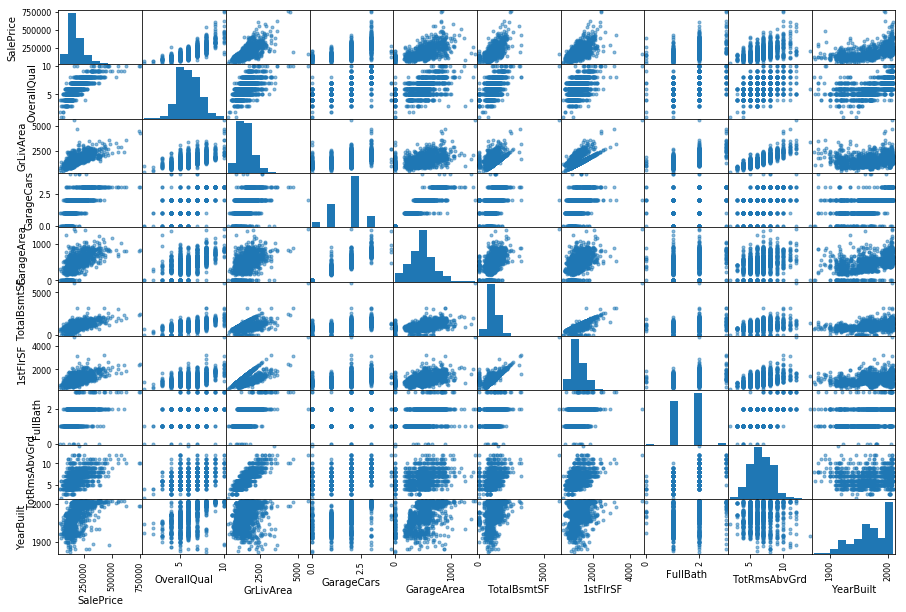

In [9]:
# plot scatter matrix for most correlated variables with SalePrice
attributes = corr_sale_price[:10].index.tolist()
scatter_matrix(train[attributes], figsize=(15, 10))
plt.show()

Some potential outliers for GrLivArea, where homes have very high square feet but low sale price. Will exclude these, as this variable is highly correlated with sales price and will likely influence the results. 

In [10]:
# remove outliers
# cutoff points below are somewhat arbitrary, initially setting to remove the two main outliers
outliers = (train['GrLivArea'] > 4000) & (train['SalePrice'] < 500000)
out_index = outliers[outliers==True].index
train.drop(train.iloc[out_index].index, inplace=True)

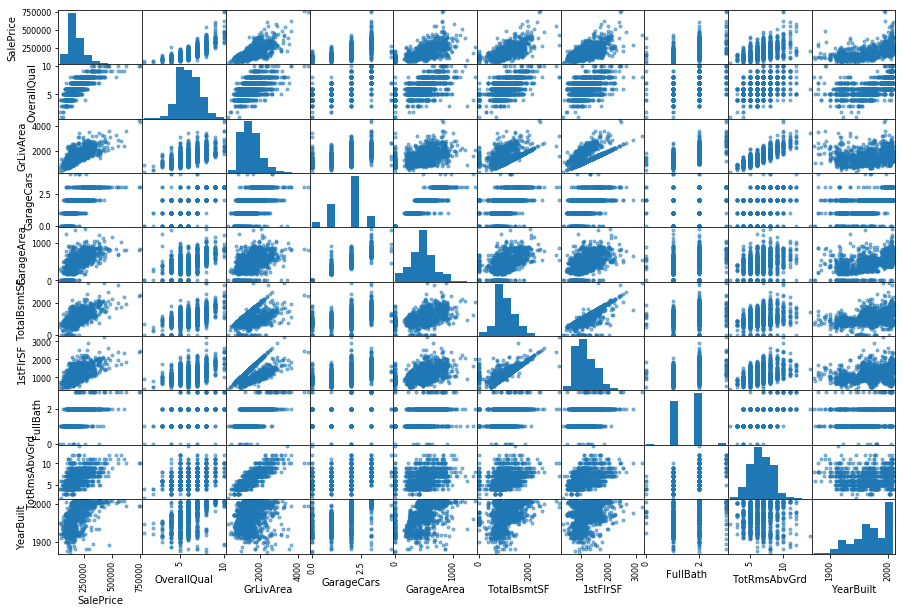

In [11]:
# check the scatter plots to ensure these were removed
attributes = corr_sale_price[:10].index.tolist()
scatter_matrix(train[attributes], figsize=(15, 10))
plt.show()

That's better, outliers are gone. We also removed the outlier in TotalBsmtSF, which must have been the same entry.

#### Data cleaning + missing data

In [12]:
# look at features with missing values
total_null = train.isnull().sum().sort_values(ascending=False)
percent_null = total_null / train.shape[0]
null_data = pd.concat([total_null, percent_null], axis=1, keys=['total_null', 'percent_null'])
null_data[null_data['percent_null'] > 0]

,total_null,percent_null
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageType,81,0.055556
GarageCond,81,0.055556
GarageFinish,81,0.055556
GarageQual,81,0.055556


For initial analysis, do the following regarding missing values:
1. drop features with percent_null > 0.33
2. replace null numerical values with the mean for that feature in the train set
3. replace null categorical values with the most frequent category

In [13]:
# process null as described above
train, test = process_null(train, test, 0.33)
# check if any remaining null values
print('Null values in train data:', train.isnull().sum().max())
print('Null values in test data:', test.isnull().sum().max())

Null values in train data: 0
Null values in test data: 0


In [14]:
# some features coded as numerical should be categorical
num_to_cat = {'MSSubClass' : {20 : 'SC20', 30 : 'SC30', 40 : 'SC40', 45 : 'SC45', 
                              50 : 'SC50', 60 : 'SC60', 70 : 'SC70', 75 : 'SC75', 
                              80 : 'SC80', 85 : 'SC85', 90 : 'SC90', 120 : 'SC120', 
                              150 : 'SC150', 160 : 'SC160', 180 : 'SC180', 190 : 'SC190'},
              'MoSold' : {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun',
                          7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}
             }
train = train.replace(num_to_cat)
test = test.replace(num_to_cat)

In [15]:
# some features coded as categorical can be coded as numerical, e.g. BsmtCond is
# no basement, poor, fair, typical, good, excellent, so there is increasing order in condition
cat_to_num = {
              'Alley' : {'Grvl' : 1, 'Pave' : 2},
              'BsmtCond' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
              'BsmtExposure' : {'No' : 0, 'Mn' : 1, 'Av': 2, 'Gd' : 3},
              'BsmtFinType1' : {'No' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 
                                'ALQ' : 5, 'GLQ' : 6},
              'BsmtFinType2' : {'No' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 
                                'ALQ' : 5, 'GLQ' : 6},
              'BsmtQual' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd' : 4, 'Ex' : 5},
              'ExterCond' : {'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd': 4, 'Ex' : 5},
              'ExterQual' : {'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd': 4, 'Ex' : 5},
              'FireplaceQu' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
              'Functional' : {'Sal' : 1, 'Sev' : 2, 'Maj2' : 3, 'Maj1' : 4, 'Mod': 5, 
                              'Min2' : 6, 'Min1' : 7, 'Typ' : 8},
              'GarageCond' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
              'GarageQual' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
              'HeatingQC' : {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
              'KitchenQual' : {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
              'LandSlope' : {'Sev' : 1, 'Mod' : 2, 'Gtl' : 3},
              'LotShape' : {'IR3' : 1, 'IR2' : 2, 'IR1' : 3, 'Reg' : 4},
              'PavedDrive' : {'N' : 0, 'P' : 1, 'Y' : 2},
              'PoolQC' : {'No' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4},
              'Street' : {'Grvl' : 1, 'Pave' : 2},
              'Utilities' : {'ELO' : 1, 'NoSeWa' : 2, 'NoSewr' : 3, 'AllPub' : 4}
             }
train = train.replace(cat_to_num)
test = test.replace(cat_to_num)

In [16]:
# as mentioned above, apply log to skewed features
train, test = transform_skewed(train, test)
# scale features using minmax scaler
train, test = scale_features(train, test)
features = get_features(test)

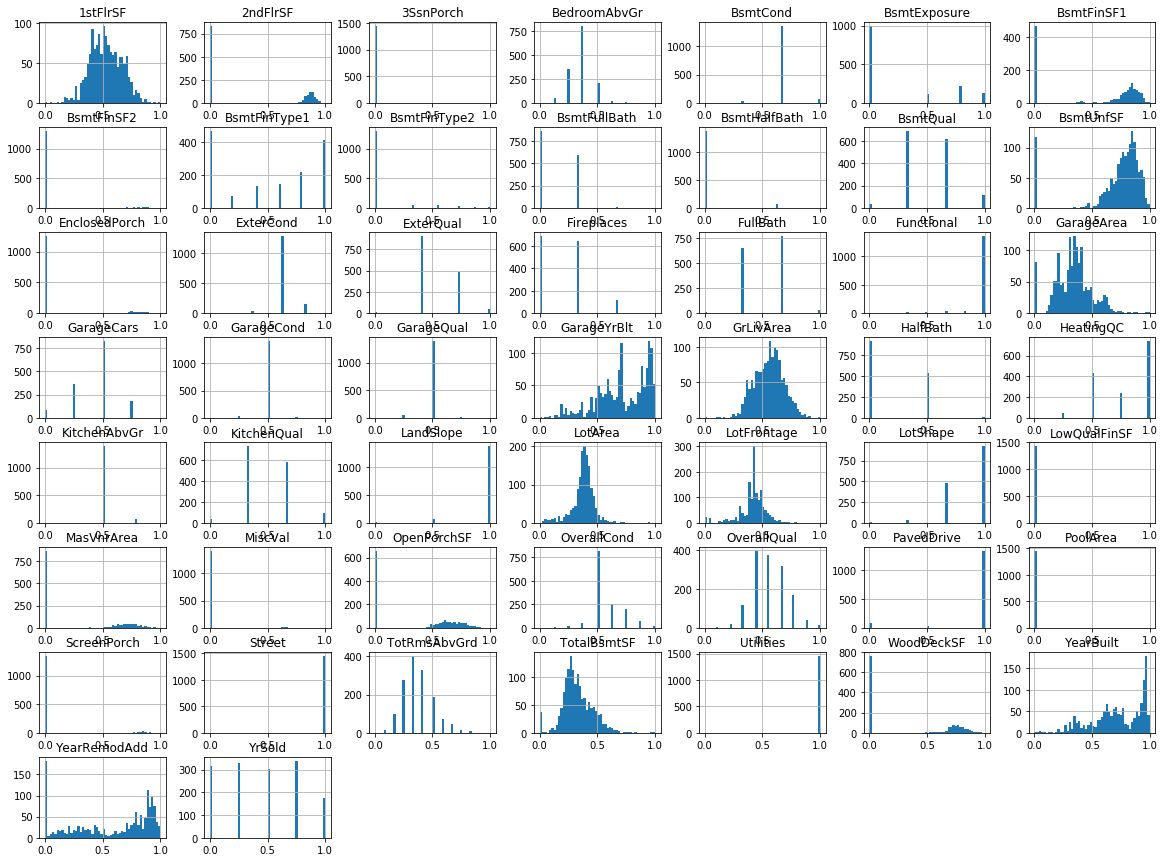

In [17]:
# look at the features after log transform and scaling
train[features['numerical']].hist(bins=50, figsize=(20,15))
plt.show()

Features look less skewed than in the raw data and now on similar scale. Fab.

In [18]:
# create indicator variables for each categorical attribute
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                     test.loc[:, 'MSSubClass':'SaleCondition']))
all_data = pd.get_dummies(all_data, drop_first=True)
train = pd.concat((all_data[:train.shape[0]], train['SalePrice']), axis=1)
test = all_data[train.shape[0]:]

#### A closer look at SalesPrice

In [19]:
# descriptive statistics
print(train['SalePrice'].describe())

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64



Skewness: 1.8793604459195012


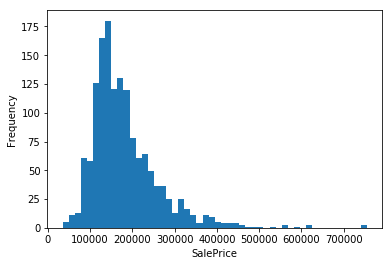

In [20]:
# histogram of sales price
print('\nSkewness:', skew(train['SalePrice']))
train['SalePrice'].plot(kind='hist', bins=50)
plt.xlabel('SalePrice')
plt.show()

Looks skewed, so let's apply log transformation.

In [21]:
target = train['SalePrice']
target = np.log1p(target)

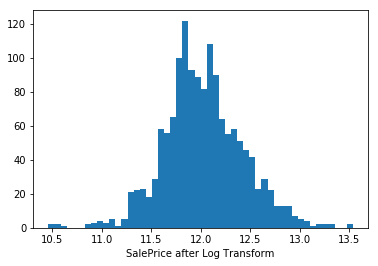

In [22]:
plt.hist(target, 50)
plt.xlabel('SalePrice after Log Transform')
plt.show()

In [23]:
# split train set into train/validation
X_train, X_val = train_test_split(train, test_size=0.2, random_state=42)
# apply log transform as done above
y_train = np.log1p(X_train['SalePrice'])
y_val = np.log1p(X_val['SalePrice'])
X_train.drop('SalePrice', axis=1, inplace=True)
X_val.drop('SalePrice', axis=1, inplace=True)

### Modeling

##### Vanilla Linear Regression

train rmse: 0.12531303566
valid rmse: 30042152607.8


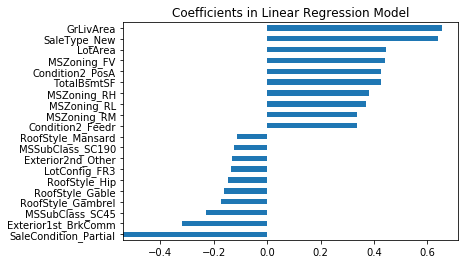

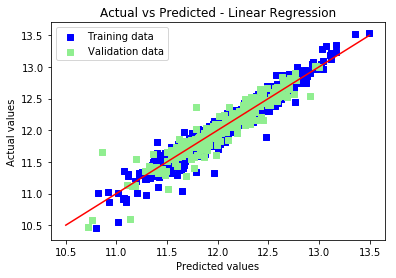

In [24]:
# fit vanilla linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# display rmse and most important features
display_results(lin_reg, X_train, y_train, X_val, y_val, coef=True,
                title='Coefficients in Linear Regression Model')
# plot actual vs predicted for training and validation data
plot_actual_pred(lin_reg, X_train, y_train, X_val, y_val, 
                 title='Actual vs Predicted - Linear Regression')

A number of the most influential variables are as we'd expect (GrLivArea, TotalBsmtSF), but there are a number of variables that I wouldn't expect to see at the top (MSZoning, Condition2, etc). 

##### Ridge Regression

train rmse: 0.117303290819
valid rmse: 0.143837536315


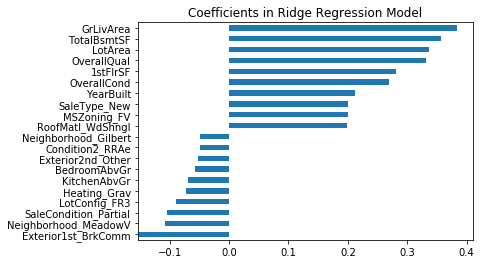

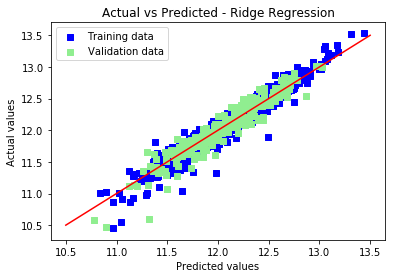

In [25]:
# fit ridge regression with built in cross validation
# ridge regression adds l2 regularization term to vanilla linear regression
ridge_cv = RidgeCV(alphas=[0.01, 0.05, 0.1, 0.5, 1.0, 5, 10, 25, 50, 100])
ridge_cv.fit(X_train, y_train)

# display rmse and most important features
display_results(ridge_cv, X_train, y_train, X_val, y_val, coef=True,
                title='Coefficients in Ridge Regression Model')
# plot actual vs predicted for training and validation data
plot_actual_pred(ridge_cv, X_train, y_train, X_val, y_val, 
                 title='Actual vs Predicted - Ridge Regression')

That looks a little better. Many of the variables correlated with SalePrice have highest coefficients and ones that we would intuitively expect to see. Train and valid rmse more similar, with lower train rmse than valid rmse.

##### Elastic Net Regression 

train rmse: 0.112580290096
valid rmse: 0.12919800573


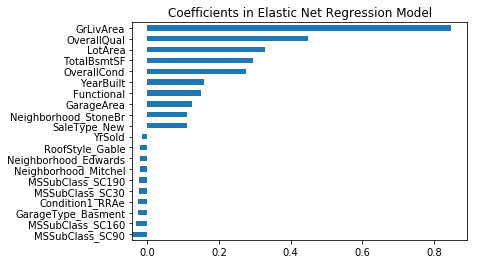

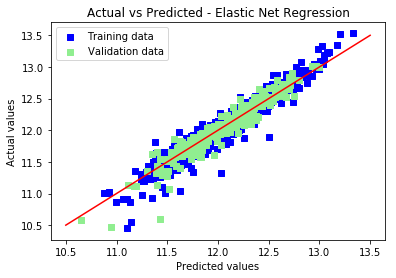

In [26]:
# fit elastic net regression with built-in cross validation
# elastic net is a middle ground between L1 and L2 regularization, i.e.
# ridge regression and lasso regression
elasnet_cv = ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                                 l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000)
elasnet_cv.fit(X_train, y_train)

# display rmse and most important features
display_results(elasnet_cv, X_train, y_train, X_val, y_val, coef=True,
                title='Coefficients in Elastic Net Regression Model')
# plot actual vs predicted for training and validation data
plot_actual_pred(elasnet_cv, X_train, y_train, X_val, y_val, 
                 title='Actual vs Predicted - Elastic Net Regression')

Better results than ridge regression, and seems to be generalizing better to validation set. Fab.

##### Gradient Boosting

train rmse: 0.115973020957
valid rmse: 0.147003663208


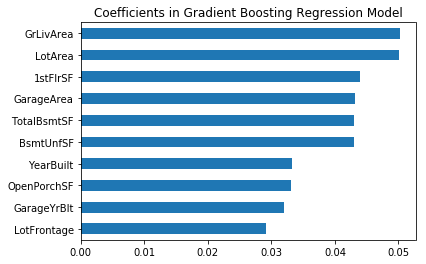

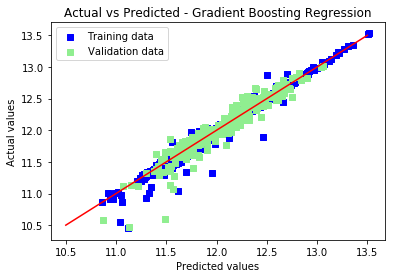

In [27]:
# fit gradient boosting regression model
# gradient boosting sequentially adds predictors to an ensemble with each
# correcting it's predecessor. each new predictor is fit to the residual 
# errors made by the previous predictor
grad_boost = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                               max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber')
grad_boost.fit(X_train, y_train)

# display rmse and most important features
display_results(grad_boost, X_train, y_train, X_val, y_val, coef=False, 
                title='Coefficients in Gradient Boosting Regression Model')
# plot actual vs predicted for training and validation data
plot_actual_pred(grad_boost, X_train, y_train, X_val, y_val, 
                 title='Actual vs Predicted - Gradient Boosting Regression')

Again decent results, though appears to be overpredicting SalePrice a bit, especially on houses with a lower SalePrice.

##### Random Forest

train rmse: 0.138537064683
valid rmse: 0.161639793126


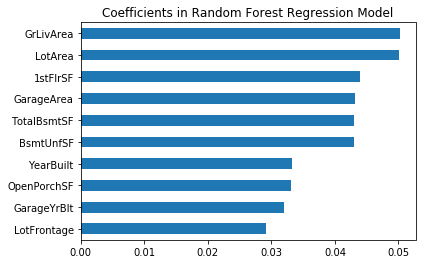

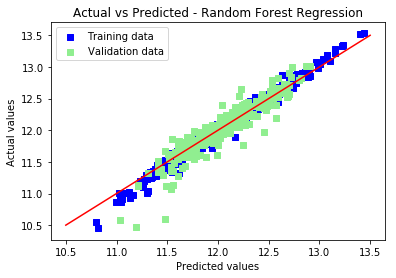

In [28]:
# fit random forest regression model
# random forest is ensemble of decision trees
rand_forest = ensemble.RandomForestRegressor(n_estimators=300)
rand_forest.fit(X_train, y_train)

# display rmse and most important features
display_results(rand_forest, X_train, y_train, X_val, y_val, coef=False, 
                title='Coefficients in Random Forest Regression Model')
# plot actual vs predicted for training and validation data
plot_actual_pred(rand_forest, X_train, y_train, X_val, y_val, 
                 title='Actual vs Predicted - Random Forest Regression')

Not quite as good of results, though this surely could be improved by further parameter tuning. Going to skip this for the time being.

##### Final Model and Submission

Create a final model prior to Kaggle submission. There hasn't been a lot of parameter tuning, so this likely won't get stellar results, but doing this for instructive purposes. We'll create an 'ensemble' using the elastic net and gradient boosting models as these had the best results. The ensemble will just be a weighted average of the two models. We'll re-fit the models on the entire training data set.

In [ ]:
# drop 'SalePrice prior to fitting model
train.drop('SalePrice', axis=1, inplace=True)

# fit elastic net regression model on entire training set
elasnet_cv_final = ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10, 25, 50, 100], 
                                 l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000)
elasnet_cv_final.fit(train, target)

# fit gradient boosting regression model on entire training set
grad_boost_final = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                           max_depth=5, max_features='sqrt',
                                           min_samples_leaf=15, min_samples_split=10, loss='huber')
grad_boost_final.fit(train, target)

In [30]:
# get prediction for each model
elasnet_preds = elasnet_cv.predict(test)
grad_boost_preds = grad_boost.predict(test)

# take average of model predictions
# apply exponential as we've been fitting log1p('SalePrice')
test_preds = np.expm1(elasnet_preds*0.5 + grad_boost_preds*0.5)

In [31]:
# write final predictions to csv file for Kaggle submission
write_to_csv(test_id, test_preds)